# Dataset Preparation
* Dataset is IMDB Movie Reviews
* Data can be found at https://www.kaggle.com/code/badnick/spoilerdetector

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Used to do plots
%matplotlib inline

import nltk
from nltk.corpus import stopwords # Stopwords 
from nltk.tokenize import word_tokenize # Word_tokenizer
from nltk.stem.porter import PorterStemmer
# from pattern.text.en import singularize

from pandarallel import pandarallel # Parallel workers on pandas dataframe

import unidecode
import re 
import time
import string
import statistics

from datetime import datetime

import contractions

In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anuraag_govindarajan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anuraag_govindarajan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anuraag_govindarajan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anuraag_govindarajan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/anuraag_govindarajan/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
stop = stopwords.words('english') # Set of stopwords
words = set(nltk.corpus.words.words()) # Set of meaniningful words

In [4]:
# Read the json file and load it as dataframe 
df_reviews = pd.read_json('IMDB_reviews.json', lines=True)

In [5]:
df_reviews.shape

(573913, 7)

In [6]:
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [7]:
df_movie_details = pd.read_json('IMDB_movie_details.json', lines=True)

In [8]:
df_movie_details.shape

(1572, 7)

In [9]:
df_movie_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


## Preliminary Analysis

Percentage distribution in the dataset of spoilers and not spoilers 

False    73.7
True     26.3
Name: is_spoiler, dtype: float64


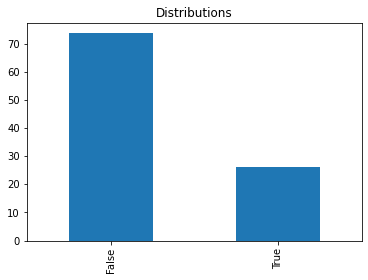

In [9]:
print('Percentage distribution in the dataset of spoilers and not spoilers \n')

# Compute distribution between classes
print(round(df_reviews.is_spoiler.value_counts(normalize=True)*100, 2)) 
# Plot distribution between classes 
round(df_reviews.is_spoiler.value_counts(normalize=True)*100, 2).plot(kind='bar')

plt.title('Distributions')
plt.show()

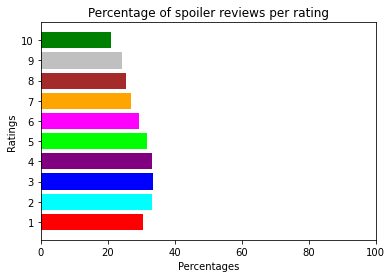

In [10]:
group = df_reviews.groupby('rating') # Groupby rating
 # Get only the spoiler reviews and group them by rating
group_is_spoiler = df_reviews[df_reviews['is_spoiler'] == True].groupby('rating')
tot_review_for_vote = group.size() # Get the number of reviews foreach vote
tot_spoiler_for_vote = group_is_spoiler.size() # Get the number of spoiler review foreach vote
percentage = ((tot_spoiler_for_vote / tot_review_for_vote) * 100) # Compute the %

# Print % graph

y_axis = ['1', '2', '3', '4', '5', '6','7','8','9','10']
x_axis = percentage.tolist()

plt.barh(y_axis,x_axis,color=['red','cyan','blue','purple','lime','magenta','orange','brown','silver','Green'])
plt.xlim(0,100)
plt.title('Percentage of spoiler reviews per rating')
plt.ylabel('Ratings')
plt.xlabel('Percentages')
plt.show()

## Text Preprocessing and Data Preparation

In [29]:
# movie_summaries = []
# for i in range(len(df_reviews)):
#     print(i)
#     mov_id = df_reviews['movie_id'][i]
#     movie_summaries.append(df_movie_details[df_movie_details['movie_id'] == mov_id]['plot_summary'])

In [30]:
# df_reviews['plot_summary'] = movie_summaries
# df_reviews.head()

In [14]:
def expand_contractions(text):
    # Expand all contractions into two words
    expanded_words = []    
    for word in text.split():
        expanded_words.append(contractions.fix(word)) 
    token_string = ' '.join(expanded_words)
    return token_string

In [15]:
def stemming_stopwords(text):
    
    # Stem words and remove stop words
    
    port_stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    
#     text_1 = ' '.join([port_stemmer.stem(token) for token in tokens if token not in stop])
    
    text_2 = ' '.join([token for token in tokens if token not in stop])
        
    return text_2

In [40]:
def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r'http\S+', '', text)
    text = unidecode.unidecode(text) 
    text = re.sub(r'[^\w\s]', '', text)
    text = expand_contractions(text)
    text = re.sub(r"[^a-zA-Z]",' ', text)
#     text = ''.join([i for i in text if not i.isdigit()])
    text = stemming_stopwords(text)
    
    return text
    

In [17]:
df_mini = df_reviews.sample(500)

In [18]:
df_mini.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
402677,30 December 2006,tt0450259,ur7407920,False,Blood Diamond is the latest in a string of rec...,6,"Jack of all trades, master of none."
95784,22 October 2011,tt1201607,ur25985431,True,"Harry Potter and the Deathly Hallows Part 2, s...",10,Great ending to an even greater franchise
14057,18 July 2016,tt0110912,ur46601812,True,Honestly... No freaking words. The way the plo...,10,The best director ever in his best film ever.
419527,9 January 2016,tt0486655,ur58619720,False,Stardust is a pretty entertaining fantasy film...,8,Entertaining
216166,7 January 2015,tt2562232,ur37907484,True,"Birdman, well I had high hopes. But that is wh...",1,I am a positive man but this made me feel very...


In [31]:
start = time.time()
df_movie_details['cleaned_summaries'] = [clean_text(t) for t in df_movie_details['plot_summary']]
print(time.time() - start)

1.343977928161621


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,cleaned_reviews
402677,30 December 2006,tt0450259,ur7407920,False,Blood Diamond is the latest in a string of rec...,6,"Jack of all trades, master of none.",blood diamond latest string recent hollywood f...
95784,22 October 2011,tt1201607,ur25985431,True,"Harry Potter and the Deathly Hallows Part 2, s...",10,Great ending to an even greater franchise,harry potter deathly hallows part starts brief...
14057,18 July 2016,tt0110912,ur46601812,True,Honestly... No freaking words. The way the plo...,10,The best director ever in his best film ever.,honestly freaking words way plot unravels make...
419527,9 January 2016,tt0486655,ur58619720,False,Stardust is a pretty entertaining fantasy film...,8,Entertaining,stardust pretty entertaining fantasy film one ...
216166,7 January 2015,tt2562232,ur37907484,True,"Birdman, well I had high hopes. But that is wh...",1,I am a positive man but this made me feel very...,birdman well high hopes trailers mostly give b...


In [32]:
df_movie_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,cleaned_summaries
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",former cia analyst jack ryan england family va...
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...,billy michael douglas paddy robert de niro arc...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,,setting camp firewood year last day everyone g...
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...,fred c dobbs bob curtin luck tampico mexico me...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...,tracy flick running unopposed years high schoo...


In [33]:
merged = df_reviews.merge(df_movie_details, 'outer', on='movie_id')
merged.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,cleaned_summaries
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10.0,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10.0,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8.0,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10.0,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8.0,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...


In [44]:
merged['review_text'] = merged['review_text'].fillna("None")

In [45]:
len(merged)

573915

In [46]:
start = time.time()
merged['cleaned_reviews'] = [clean_text(t) for t in merged['review_text']]
print(time.time() - start)

1103.992791891098


In [47]:
merged.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,cleaned_summaries,cleaned_reviews
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10.0,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,oscar year shawshank redemption written direct...
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10.0,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,shawshank redemption without doubt one brillia...
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8.0,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,believe film best story ever told film tell wh...
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10.0,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,yes spoilers herethis film emotional impact fi...
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8.0,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,heart extraordinary movie brilliant indelible ...


In [48]:
# merged.to_csv("cleaned_reviews_summaries.zip")

In [10]:
full_df = pd.read_csv("cleaned_reviews_summaries.zip")

/Users/anuraag_govindarajan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Generate Vocab and Embeddings

In [92]:
from sklearn.model_selection import train_test_split
import torch

In [11]:
full_df.head()

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,cleaned_summaries,cleaned_reviews
0,0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10.0,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,oscar year shawshank redemption written direct...
1,1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10.0,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,shawshank redemption without doubt one brillia...
2,2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8.0,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,believe film best story ever told film tell wh...
3,3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10.0,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,yes spoilers herethis film emotional impact fi...
4,4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8.0,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"['Crime', 'Drama']",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",chronicles experiences formerly successful ban...,heart extraordinary movie brilliant indelible ...


In [53]:
df_mini = full_df.sample(500) # Small Size to test out functions

In [54]:
df_mini.head()

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,cleaned_summaries,cleaned_reviews
402212,402212,24 March 2007,tt0416449,ur4348672,True,"When one mentions Sparta and the Greek Cities,...",1.0,Waste of time,In the Battle of Thermopylae of 480 BC an alli...,1h 57min,"['Action', 'Fantasy']",7.7,2007-03-09,Spartan customs are harsh. The Spartans inspec...,battle thermopylae alliance greek citystates f...,one mentions sparta greek cities expectations ...
377561,377561,22 November 2005,tt0330373,ur3083766,False,"As a massive fan of both books and movies, eac...",10.0,The very best yet!,Harry's fourth year at Hogwarts is about to st...,2h 37min,"['Adventure', 'Family', 'Fantasy']",7.7,2005-11-18,"Harry, Ron and Hermione enter their fourth yea...",harrys fourth year hogwarts start enjoying sum...,massive fan books movies right seems personall...
154252,154252,24 September 2011,tt0780504,ur3088629,True,"Just got back from the movie, which in the lan...",10.0,"Hot review, after the screening",A mysterious man who has multiple jobs as a ga...,1h 40min,"['Crime', 'Drama']",7.8,2011-09-16,The Driver (Ryan Gosling) who lives in an apar...,mysterious man multiple jobs garage mechanic h...,got back movie language star trek restores fai...
327882,327882,10 July 2003,tt0274812,ur2541295,False,What this movie is about you saw before you ca...,10.0,"All praise, but with a few bad words, but how ...",An emotionally fragile woman recently released...,1h 47min,"['Comedy', 'Drama', 'Romance']",7.0,2002-10-11,"Lee Holloway (Maggie Gyllenhaal), is a sociall...",emotionally fragile woman recently released me...,movie saw came comments guess cut chase tell s...
271233,271233,29 January 2017,tt4034228,ur2496397,False,"""Manchester by the Sea"" takes place in the dea...",9.0,"""Manchester"" is long and grim, but it's reflec...","Lee Chandler is a brooding, irritable loner wh...",2h 17min,['Drama'],7.9,2016-12-16,"We see footage of the fishing village, Manches...",lee chandler brooding irritable loner works ha...,manchester sea takes place dead winter small m...


In [55]:
EMB_DIM = 300
vocab = set()
word_to_id = dict()
id_to_word = dict()
word_to_count = dict()
vocab_size = 1

In [89]:
max_len = 30 # placeholder value

In [56]:
# cols = ['cleaned_reviews', 'cleaned_summaries'] # Use if you want vocab to include plot summaries
cols = ['cleaned_reviews'] # Use if you want vocab to include just review text

In [57]:
def generate_vocab(cols):
    
    global vocab_size, vocab
    global word_to_id, id_to_word, word_to_count
    global full_df
    global df_mini
    cleaned_reviews_ids = []
    cleaned_summaries_ids = []
    
    for index, row in df_mini.iterrows():
        
        for c in cols:
            
            s2n = []
            split = row[c].split()
            
            for word in split:
                
                if word not in vocab:
                    vocab.add(word)
                    word_to_id[word] = vocab_size
                    # word_to_count[word] = 1
                    s2n.append(vocab_size)
                    id_to_word[vocab_size] = word
                    vocab_size += 1
                    
                else:
                    # word_to_count[word] += 1
                    s2n.append(word_to_id[word])
                    
            
            df_mini.at[index, c] = s2n
            

In [58]:
generate_vocab(cols)

In [59]:
print(len(vocab))

13655


In [60]:
df_mini.head()

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis,cleaned_summaries,cleaned_reviews
402212,402212,24 March 2007,tt0416449,ur4348672,True,"When one mentions Sparta and the Greek Cities,...",1.0,Waste of time,In the Battle of Thermopylae of 480 BC an alli...,1h 57min,"['Action', 'Fantasy']",7.7,2007-03-09,Spartan customs are harsh. The Spartans inspec...,battle thermopylae alliance greek citystates f...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
377561,377561,22 November 2005,tt0330373,ur3083766,False,"As a massive fan of both books and movies, eac...",10.0,The very best yet!,Harry's fourth year at Hogwarts is about to st...,2h 37min,"['Adventure', 'Family', 'Fantasy']",7.7,2005-11-18,"Harry, Ron and Hermione enter their fourth yea...",harrys fourth year hogwarts start enjoying sum...,"[139, 140, 141, 142, 143, 144, 145, 146, 147, ..."
154252,154252,24 September 2011,tt0780504,ur3088629,True,"Just got back from the movie, which in the lan...",10.0,"Hot review, after the screening",A mysterious man who has multiple jobs as a ga...,1h 40min,"['Crime', 'Drama']",7.8,2011-09-16,The Driver (Ryan Gosling) who lives in an apar...,mysterious man multiple jobs garage mechanic h...,"[330, 231, 257, 331, 332, 333, 334, 335, 336, ..."
327882,327882,10 July 2003,tt0274812,ur2541295,False,What this movie is about you saw before you ca...,10.0,"All praise, but with a few bad words, but how ...",An emotionally fragile woman recently released...,1h 47min,"['Comedy', 'Drama', 'Romance']",7.0,2002-10-11,"Lee Holloway (Maggie Gyllenhaal), is a sociall...",emotionally fragile woman recently released me...,"[257, 448, 449, 450, 451, 157, 452, 453, 448, ..."
271233,271233,29 January 2017,tt4034228,ur2496397,False,"""Manchester by the Sea"" takes place in the dea...",9.0,"""Manchester"" is long and grim, but it's reflec...","Lee Chandler is a brooding, irritable loner wh...",2h 17min,['Drama'],7.9,2016-12-16,"We see footage of the fishing village, Manches...",lee chandler brooding irritable loner works ha...,"[476, 477, 478, 38, 479, 480, 481, 482, 483, 4..."


In [62]:
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []

In [83]:
def split_data(cols):
    
    global X_train, y_train
    global X_test, y_test
    global X_val, y_val
    
    train_ratio = 0.8 # Split into training and validation
    test_ratio = 0.85 # Split into training and testing
    
    X = list(df_mini['cleaned_reviews'])
    y = list(df_mini['is_spoiler'].astype(int))
    
    X_rem, X_test, y_rem, y_test = train_test_split(X, y, train_size=test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, train_size=train_ratio)
    
    # X_train = [X_train[c] for c in cols]
    # X_val = [X_val[c] for c in cols]
    # X_test = [X_test[c] for c in cols]
    
    # y_train = y_train.values
    # y_test = y_test.values
    # y_val = y_val.values

In [84]:
split_data(cols)

In [85]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

340 340 75 75


In [93]:
def pad_sequences(X_list):
    
    X_padded = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(l) for l in X_list]).type(torch.LongTensor) # padding the sequences with 0
    X_mask   = torch.nn.utils.rnn.pad_sequence([torch.as_tensor([1.0] * len(l)) for l in X_list]).type(torch.FloatTensor)
    
    return X_padded, X_mask

In [95]:
X_train = pad_sequences(X_train)[0]

In [96]:
X_train

tensor([[[ 2479,  2054,   327,  ...,   219,  1439,  2998],
         [    1,     1,     1,  ...,     1,     1,     1]],

        [[ 1565, 12148,   257,  ...,  1310,   257,  2999],
         [    1,     1,     1,  ...,     1,     1,     1]],

        [[ 1516,   257,   117,  ...,  2538,    28,   327],
         [    1,     1,     1,  ...,     1,     1,     1]],

        ...,

        [[    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]],

        [[    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]],

        [[    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]]])

In [99]:
# Read GloVe embeddings.
def read_GloVe(filename):
    
    embeddings = {}
    for line in open(filename).readlines():
        #print(line)
        fields = line.strip().split(" ")
        word = fields[0]
        embeddings[word] = [float(x) for x in fields[1:]]
        
    return embeddings

In [98]:
GloVe = read_GloVe("glove/glove.6B.300d.txt")

print(GloVe["the"])
print("dimension of glove embedding:", len(GloVe["the"]))

[0.04656, 0.21318, -0.0074364, -0.45854, -0.035639, 0.23643, -0.28836, 0.21521, -0.13486, -1.6413, -0.26091, 0.032434, 0.056621, -0.043296, -0.021672, 0.22476, -0.075129, -0.067018, -0.14247, 0.038825, -0.18951, 0.29977, 0.39305, 0.17887, -0.17343, -0.21178, 0.23617, -0.063681, -0.42318, -0.11661, 0.093754, 0.17296, -0.33073, 0.49112, -0.68995, -0.092462, 0.24742, -0.17991, 0.097908, 0.083118, 0.15299, -0.27276, -0.038934, 0.54453, 0.53737, 0.29105, -0.0073514, 0.04788, -0.4076, -0.026759, 0.17919, 0.010977, -0.10963, -0.26395, 0.07399, 0.26236, -0.1508, 0.34623, 0.25758, 0.11971, -0.037135, -0.071593, 0.43898, -0.040764, 0.016425, -0.4464, 0.17197, 0.046246, 0.058639, 0.041499, 0.53948, 0.52495, 0.11361, -0.048315, -0.36385, 0.18704, 0.092761, -0.11129, -0.42085, 0.13992, -0.39338, -0.067945, 0.12188, 0.16707, 0.075169, -0.015529, -0.19499, 0.19638, 0.053194, 0.2517, -0.34845, -0.10638, -0.34692, -0.19024, -0.2004, 0.12154, -0.29208, 0.023353, -0.11618, -0.35768, 0.062304, 0.35884, 0.

In [109]:
def init_glove(GloVe):
    
    global EMB_DIM
    
    pretrained = torch.zeros(max(word_to_id.values()) + 1, EMB_DIM)
    scale = torch.sqrt(torch.Tensor([3.0 / EMB_DIM]))[0]
    for word, i in word_to_id.items():
        if word in GloVe:
            pretrained[i] = torch.FloatTensor(GloVe[word])
        else:
            vect = torch.FloatTensor(EMB_DIM).uniform_(-scale, scale)
            pretrained[i] = torch.FloatTensor(vect)

    return pretrained

In [110]:
pretrained = init_glove(GloVe)

In [111]:
pretrained.shape

torch.Size([13656, 300])